Description


In [1]:
#install libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tueplots

import sys
print(sys.executable)


/Users/madelinemiller/Desktop/data_literacy/geonews_femicide/source/.venv/bin/python


In [2]:
#set source and output paths
source_path = '../../data/'
csv_output_path = '../../data/processed/'
figure_output_path = '../../paper/figures/'

#upload raw query data
df_32_raw = pd.read_csv(f'{source_path}repository_queries/500000_32_homicide-female_DE.csv') 
#upload manually tagged articles with json data
df_tag = pd.read_csv(f'{source_path}processed/manual-tag_all_parsedson.csv') 
#upload keyword data
df_key = pd.read_csv(f'{source_path}manual_tag/femicide_keywords.csv')
#upload top 25 data
df_25 = pd.read_csv(f'{source_path}processed/7-14_22-24_26-27_29-32_2017-2023_top25.csv')

#filter to only one entry per NUTS
df_32_raw['NUTS'] = df_32_raw['NUTS'].fillna('').astype(str)
df_32 = df_32_raw.groupby('id').agg({
    'NUTS': lambda x: ', '.join(sorted(set(code for code in x if code.startswith('DE')))),
    'url': 'first',
    'hostname': 'first',
    'date': 'first',
    'cos_dist': 'first' # these values will all be the same
    }).reset_index()

In [3]:
#get subsets of sampled and checked articles

#ids that were sampled and had a T/F outcome 
#filter out nan for 'query_32_cosine_bin' and 'woman_murdered'
#select only id
df_sampled = df_tag.dropna(subset=['query_32_cosine_bin', 'woman_murdered'])
#get list of ids
sampled_ids = df_sampled['id']
#filter raw dataset to just those ids
df_32_sampled = df_32[df_32['id'].isin(sampled_ids)].copy()

#all ids that were manualy checked that had a T/F outcome
#filter out nan for 'woman_murdered'
df_checked = df_tag[df_tag['woman_murdered'].notna()]
#get list of ids
checked_ids = df_checked['id']
#filter raw dataset to just those ids
df_32_checked = df_32[df_32['id'].isin(checked_ids)].copy()


# Verify the result
print(f"Original shape: {df_tag.shape}")
print(f"sample shape: {df_sampled.shape}")
print(f"all checked shape: {df_checked.shape}")
print(f"32 sample shape: {df_32_sampled.shape}")
print(f"32 all checked shape: {df_32_checked.shape}") 
#less than all checked because some checked articles were not included in q 32 results

Original shape: (1666, 20)
sample shape: (677, 20)
all checked shape: (1028, 20)
32 sample shape: (677, 6)
32 all checked shape: (1014, 6)


In [4]:
#filter to only articles not in the q32 results (should be 14)
df_32_ids = df_32_checked['id']
checked_ids_notq32 = df_checked[df_checked['id'].isin(df_32_ids)==False].copy()
print(f"NOT 32 all checked shape: {checked_ids_notq32.shape}") 

print(checked_ids_notq32['woman_murdered'])

NOT 32 all checked shape: (14, 20)
86     False
95     False
97     False
100    False
101    False
104    False
107    False
111    False
115    False
125    False
129    False
130    False
213    False
215    False
Name: woman_murdered, dtype: object


In [5]:
#how many with cosine distance over .23 for Q32 were 1. relevant and 2. in top 25 of another query
#add 'woman_murdered' relevance from df_tag to top_25
# Add 'woman_murdered' relevance from df_tag to top_25 (don't do it if it's already done)

df_25_tag = df_25

if 'woman_murdered' not in df_25_tag.columns:
    df_25_tag = df_25_tag.merge(
        df_tag[['id', 'woman_murdered']], 
        on='id', 
        how='left'
    ).copy()

# Filter to Q32 articles with cosine distance > 0.23
q32_highdist = df_25_tag[
    (df_25_tag['cos_dist_32_homicide-female_DE'] > 0.23)
].copy()

q32_highdist.head()

# How many were relevant?
relevant_count = q32_highdist['woman_murdered'].sum()
print(f"Q32 articles with cos_dist > 0.23 that were relevant: {relevant_count}")

# How many were NOT relevant?
not_relevant_count = (q32_highdist['woman_murdered'] == 0).sum()
print(f"Q32 articles with cos_dist > 0.23 that were NOT relevant: {not_relevant_count}")

# How many were not useable (NaN)?
nan_count = q32_highdist['woman_murdered'].isna().sum()
print(f"Q32 articles with cos_dist > 0.23 that were not able to be verified: {nan_count}")

# Total
print(f"\nTotal Q32 articles with cos_dist > 0.23: {len(q32_highdist)}")


Q32 articles with cos_dist > 0.23 that were relevant: 15
Q32 articles with cos_dist > 0.23 that were NOT relevant: 10
Q32 articles with cos_dist > 0.23 that were not able to be verified: 6

Total Q32 articles with cos_dist > 0.23: 31


In [7]:
#how many relevant top 25 are not in Q32?
q32_highdist_rel = q32_highdist[q32_highdist['woman_murdered'] == True]

# Get cosine rank for all queries except Q32
rank_columns = [col for col in q32_highdist_rel.columns if col.startswith('cos_rank_') and 'cos_rank_32_homicide-female_DE' not in col]

# Check how many Q32 high distance articles have rank <= 25 in other queries
articles_top25_in_other_queries = []

for idx, row in q32_highdist_rel.iterrows():
    article_id = row['id']
    
    # Check if this article appears in top 25 of any other query
    for rank_col in rank_columns:
        if pd.notna(row[rank_col]) and row[rank_col] <= 25:
            articles_top25_in_other_queries.append(article_id)
            break  # Count each article only once

unique_count = len(set(articles_top25_in_other_queries))
print(f"Q32 high distance articles also in top 25 of another query: {unique_count}")
print(f"Out of {len(q32_highdist_rel)} total Q32 high distance articles")

#filter raw dataset to just those ids
df_highcos_top25 = q32_highdist_rel[q32_highdist_rel['id'].isin(articles_top25_in_other_queries)].copy()

#return csv
df_highcos_top25.to_csv(f'{csv_output_path}top25_notq32.csv', index=False)

Q32 high distance articles also in top 25 of another query: 15
Out of 15 total Q32 high distance articles


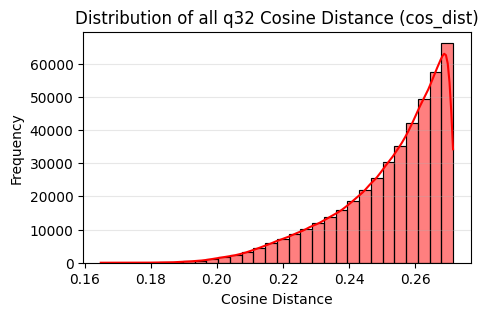

In [8]:
#what is the distribution of the distances of all articles? 
plt.figure(figsize=(5, 3))
sns.histplot(df_32['cos_dist'], kde=True, color='red', bins=30)
    
plt.title('Distribution of all q32 Cosine Distance (cos_dist)')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
    
plt.show()

597     0.253980
639     0.267044
744     0.262133
1108    0.271431
1488    0.215143
Name: cos_dist, dtype: float64


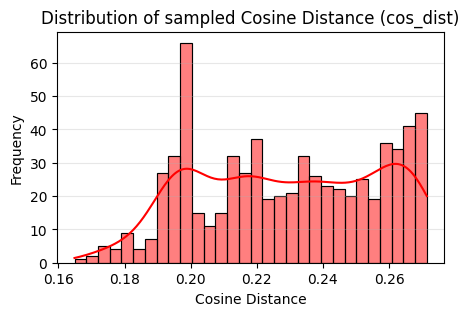

In [9]:
print(df_32_sampled['cos_dist'].head())
#what is the distribution of the distances of sampled articles?
plt.figure(figsize=(5, 3))
sns.histplot(data=df_32_sampled['cos_dist'], kde=True, color='red', bins=30)
    
plt.title('Distribution of sampled Cosine Distance (cos_dist)')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
    
plt.show()

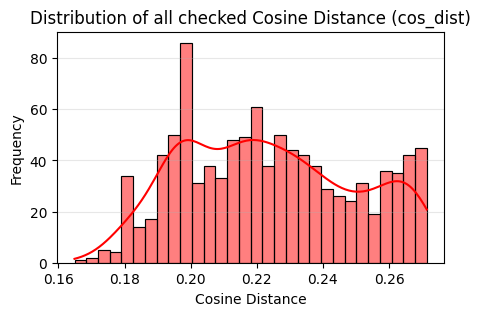

In [10]:
#what is the distribution of the distances of all checked articles?
plt.figure(figsize=(5, 3))
sns.histplot(data=df_32_checked['cos_dist'], kde=True, color='red', bins=30)
    
plt.title('Distribution of all checked Cosine Distance (cos_dist)')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
    
plt.show()

7
[nan '(0.2, 0.22]' '(0.18, 0.2]' '(0.16, 0.18]' '(0.22, 0.24]'
 '(0.24, 0.26]' '(0.26, 0.28]']
   query_32_cosine_bin  woman_murdered  count
0         (0.16, 0.18]            True     20
1          (0.18, 0.2]           False      1
2          (0.18, 0.2]            True    135
3          (0.2, 0.22]           False     10
4          (0.2, 0.22]            True    121
5         (0.22, 0.24]           False     32
6         (0.22, 0.24]            True     98
7         (0.24, 0.26]           False     87
8         (0.24, 0.26]            True     41
9         (0.26, 0.28]           False    114
10        (0.26, 0.28]            True     18


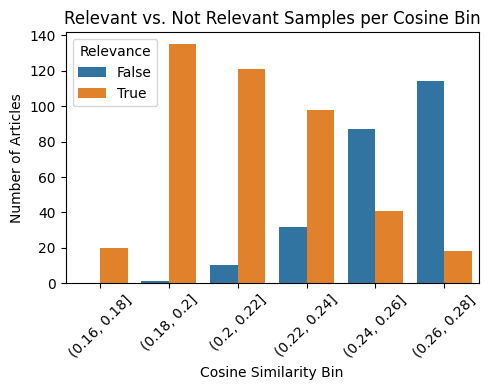

In [11]:
#For the query, how many relavant/irrelavant articles are included in each cosine bin?

#create a list of bins
cos_bin = df_tag['query_32_cosine_bin'].unique()
print(len(cos_bin))
print(cos_bin)

# Count relevant and not relevant per bin
bin_counts = df_sampled.groupby(['query_32_cosine_bin', 'woman_murdered']).size().reset_index(name='count')

print(bin_counts)

# sort bins numerically
bin_order = ['(0.16, 0.18]', '(0.18, 0.2]', '(0.2, 0.22]', '(0.22, 0.24]', '(0.24, 0.26]', '(0.26, 0.28]']
bin_counts['query_32_cosine_bin'] = pd.Categorical(bin_counts['query_32_cosine_bin'], categories=bin_order, ordered=True)
bin_counts = bin_counts.sort_values('query_32_cosine_bin')

# Plotting
plt.figure(figsize=(5,4))
sns.barplot(
    data=bin_counts,
    x='query_32_cosine_bin',
    y='count',
    hue='woman_murdered'
)
plt.title('Relevant vs. Not Relevant Samples per Cosine Bin')
plt.xlabel('Cosine Similarity Bin')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend(title='Relevance')
plt.tight_layout()
plt.show()

In [13]:
 df_32_checked.head()

,id,NUTS,url,hostname,date,cos_dist
597,005a0613-da7a-456d-b40c-c552294bff2f,"DE404, DE408, DE80J",https://www.volksstimme.de/panorama/obduktions...,volksstimme.de,2023-06-28,0.253980
639,00607b72-6c70-4bd2-9a8e-341fc29be756,"DE600, DEF09, DEF0E",https://www.bild.de/regional/hamburg/hamburg-a...,bild.de,2020-05-05,0.267044
744,00748561-ec63-4b22-bd89-78be9a6aa66b,"DE212, DE214, DE21M",http://www.heimatzeitung.de/lokales/landkreis_...,heimatzeitung.de,2017-01-08,0.262133
1108,00acf420-444c-4d22-8434-280894a04f39,DE731,http://www.fnp.de/rhein-main/Gedenken-an-Halit...,fnp.de,2017-04-06,0.271431
1488,00ec12a3-59be-4bfd-9c07-2ae1e38c96ac,DE300,https://www.merkur.de/deutschland/berlin/tote-...,merkur.de,2023-04-18,0.215143


all_cosine_bin
(0.16, 0.18]    0
(0.18, 0.2]     0
(0.2, 0.22]     0
(0.22, 0.24]    0
(0.24, 0.26]    0
(0.26, 0.28]    0
(0.28+)         0
Name: count, dtype: int64
   query_32_cosine_bin  woman_murdered  count
0         (0.16, 0.18]            True     20
1          (0.18, 0.2]           False      1
2          (0.18, 0.2]            True    135
3          (0.2, 0.22]           False     10
4          (0.2, 0.22]            True    121
5         (0.22, 0.24]           False     32
6         (0.22, 0.24]            True     98
7         (0.24, 0.26]           False     87
8         (0.24, 0.26]            True     41
9         (0.26, 0.28]           False    114
10        (0.26, 0.28]            True     18


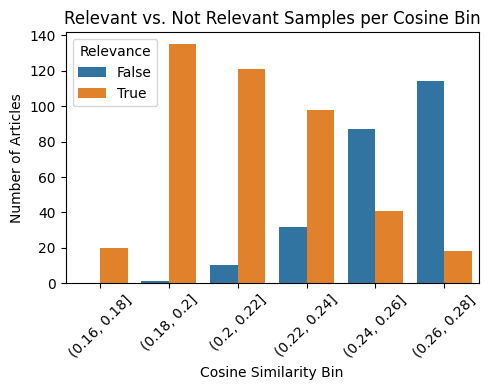

In [18]:
#For all checked results, how many relavant/irrelavant articles are included in each cosine bin?

#sort all checked into bins (add cosine bin row)
df_25['all_cosine_bin'] = pd.cut(
    df_32_checked['cos_dist'],
    bins=[0.16, 0.18, 0.20, 0.22, 0.24, 0.26, 0.28, np.inf],
    labels=['(0.16, 0.18]', '(0.18, 0.2]', '(0.2, 0.22]', 
            '(0.22, 0.24]', '(0.24, 0.26]', '(0.26, 0.28]', '(0.28+)']
)

# Check result
print(df_25['all_cosine_bin'].value_counts())

# Count relevant and not relevant per bin
bin_counts = df_sampled.groupby(['query_32_cosine_bin', 'woman_murdered']).size().reset_index(name='count')

print(bin_counts)

# sort bins numerically
bin_order = ['(0.16, 0.18]', '(0.18, 0.2]', '(0.2, 0.22]', '(0.22, 0.24]', '(0.24, 0.26]', '(0.26, 0.28]']
bin_counts['query_32_cosine_bin'] = pd.Categorical(bin_counts['query_32_cosine_bin'], categories=bin_order, ordered=True)
bin_counts = bin_counts.sort_values('query_32_cosine_bin')

# Plotting
plt.figure(figsize=(5,4))
sns.barplot(
    data=bin_counts,
    x='query_32_cosine_bin',
    y='count',
    hue='woman_murdered'
)
plt.title('Relevant vs. Not Relevant Samples per Cosine Bin')
plt.xlabel('Cosine Similarity Bin')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend(title='Relevance')
plt.tight_layout()
plt.show()

In [ ]:
#apply to different queries

#upload raw data


In [ ]:
#Headline analysis

In [16]:
# Keyword Analysis: 
# For each keyword, get a count of how many relevant and irrelevant articles are associated with it

# Ensure the keyword column is lowercase for matching
df_key['keyword'] = df_key['keyword'].str.lower()
df_tag['found_keywords'] = df_tag['found_keywords'].str.lower()
df_tag['not_found_keywords'] = df_tag['not_found_keywords'].str.lower()

# Make sure keywords are strings
df_tag['found_keywords'] = df_tag['found_keywords'].astype(str)

# Filter rows where 'has_keyword_data' equals True (boolean)
df_tag_key = df_tag[df_tag['has_keyword_data'] == True].copy()

# Split by comma
df_tag_key['found_keywords_list'] = df_tag_key['found_keywords'].str.split(',')

# Remove extra whitespace and convert to lowercase
df_tag_key['found_keywords_list'] = df_tag_key['found_keywords_list'].apply(
    lambda x: [kw.strip().lower() for kw in x] if isinstance(x, list) else []
)

# Explode into multiple rows
df_tag_key = df_tag_key.explode('found_keywords_list')

# Remove empty keywords and NaN values
df_tag_key = df_tag_key[df_tag_key['found_keywords_list'].notna()]
df_tag_key = df_tag_key[df_tag_key['found_keywords_list'] != '']

print(f"Total rows after processing: {len(df_tag_key)}")

# Create summary: count of relevant and irrelevant articles per keyword
# Assuming you have a column that indicates relevance (adjust column name as needed)
# Common column names might be: 'relevant', 'is_relevant', 'woman_murdered', etc.

keyword_summary = df_tag_key.groupby('found_keywords_list').agg(
    total_articles=('id', 'nunique'),
    relevant_count=('woman_murdered', lambda x: (x == True).sum()),
    irrelevant_count=('woman_murdered', lambda x: (x == False).sum())
).reset_index()

keyword_summary.columns = ['keyword', 'total_articles', 'relevant_count', 'irrelevant_count']

# Sort by total articles descending
keyword_summary = keyword_summary.sort_values('total_articles', ascending=False)

print(f"\nKeyword Summary:")
print(keyword_summary)

keyword_summary.to_csv(f'{csv_output_path}keyword_summary.csv', index=False)

Total rows after processing: 4841

Keyword Summary:
             keyword  total_articles  relevant_count  irrelevant_count
38               tat             472             297               169
4                ehe             424             261               158
29              mord             308             197               104
43               tot             281             184                94
26            gewalt             277             164               109
25           getötet             265             184                79
40               tod             258             187                68
34             opfer             258             152               103
51        verdächtig             201             148                53
35           partner             191              95                92
52       verdächtige             182             134                48
30             morde             165              94                68
47            tötung     

In [ ]:
#Keyword accuracy versus cosine distance

Top 10 Keywords - Highest Relevance Rate:
         keyword  total_articles  relevance_rate  relevant_count  \
5        ehefrau              51       78.431373              40   
31      mordfall              23       78.260870              18   
7        ehemann              78       76.923077              60   
46        tötete              93       75.268817              70   
3        bluttat              23       73.913043              17   
45     totschlag              99       73.737374              73   
51    verdächtig             201       73.631841             148   
52   verdächtige             182       73.626374             134   
40           tod             258       72.480620             187   
53  verdächtigen              93       70.967742              66   

    irrelevant_count  
5                 11  
31                 5  
7                 18  
46                23  
3                  4  
45                25  
51                53  
52                48  
40

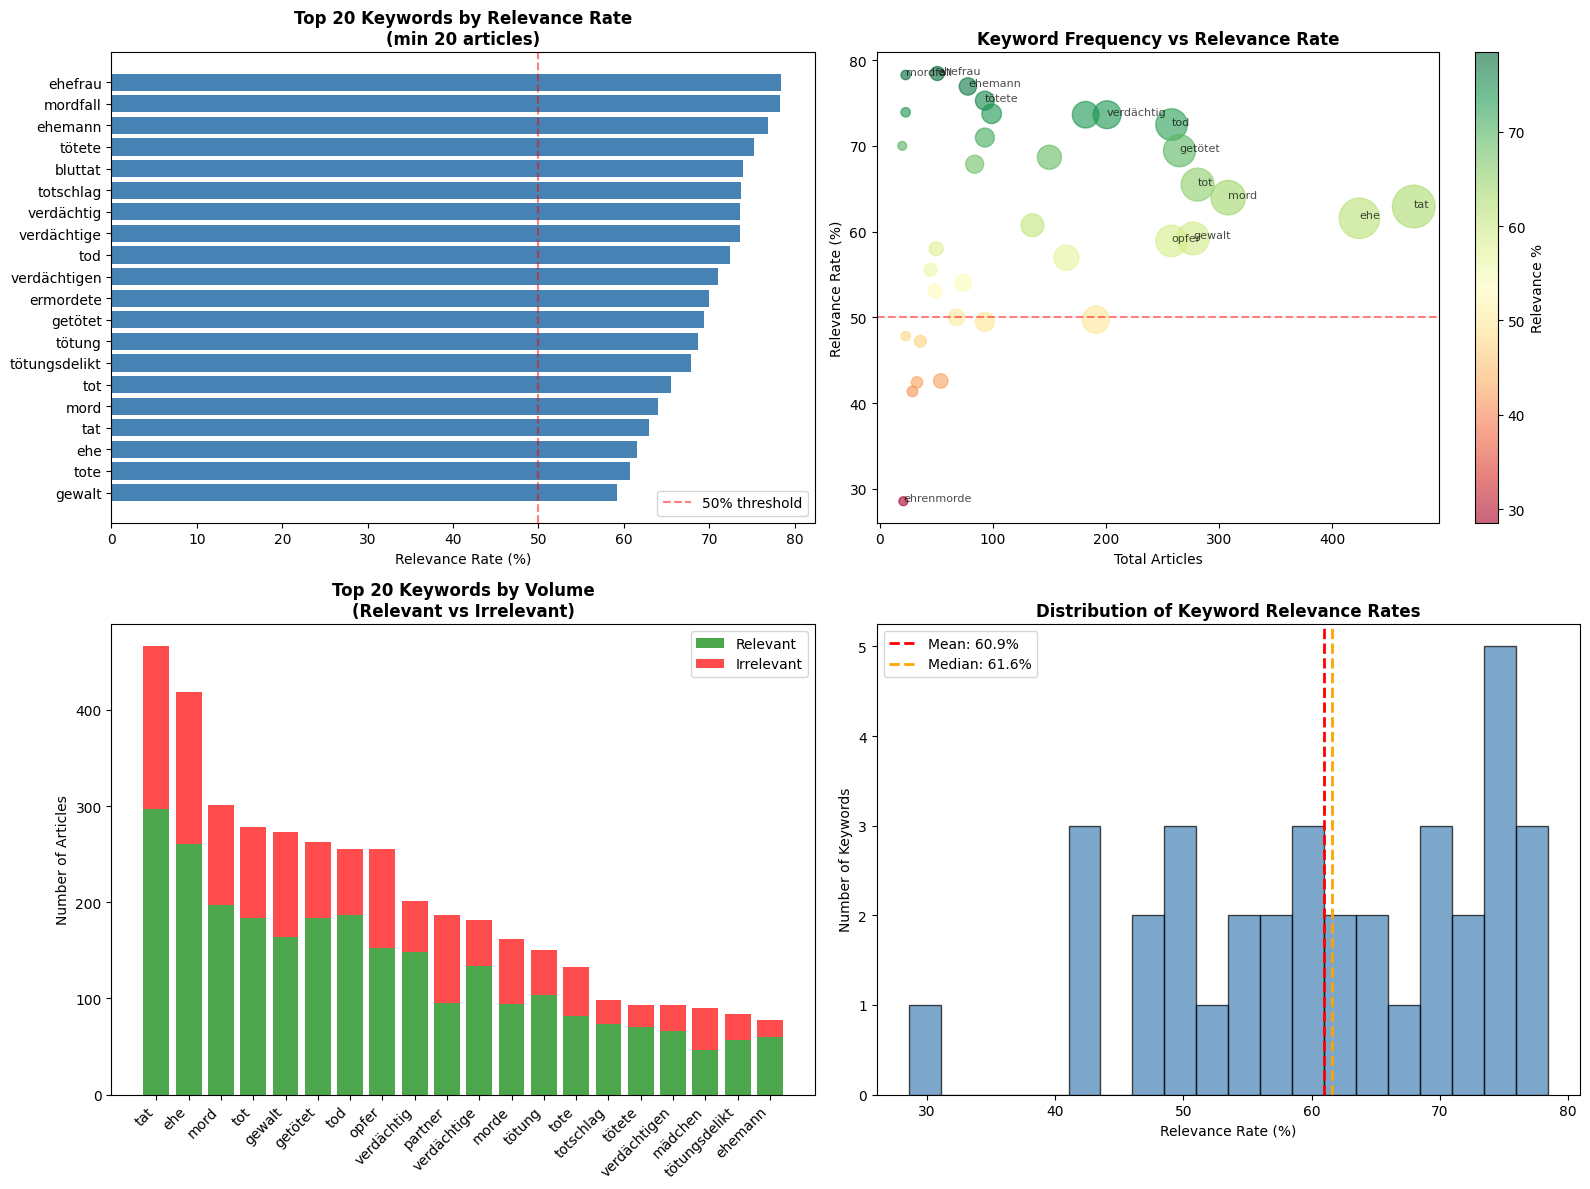


STATISTICAL SUMMARY (Keywords with 20+ articles)
Mean Relevance Rate: 60.94%
Median Relevance Rate: 61.56%
Std Dev: 12.45%

Keywords above 70% relevance (strong predictors): 10
Keywords below 50% relevance (weak/negative predictors): 8


In [14]:
# Calculate relevance metrics for each keyword
keyword_summary['relevance_rate'] = (
    keyword_summary['relevant_count'] / keyword_summary['total_articles'] * 100
)

# Calculate irrelevance rate
keyword_summary['irrelevance_rate'] = (
    keyword_summary['irrelevant_count'] / keyword_summary['total_articles'] * 100
)

# Filter keywords with at least 20 articles for more reliable statistics
keyword_filtered = keyword_summary[keyword_summary['total_articles'] >= 20].copy()

# Sort by relevance rate
keyword_filtered = keyword_filtered.sort_values('relevance_rate', ascending=False)

print("Top 10 Keywords - Highest Relevance Rate:")
print(keyword_filtered[['keyword', 'total_articles', 'relevance_rate', 'relevant_count', 'irrelevant_count']].head(10))
print("\n" + "="*80 + "\n")

print("Top 10 Keywords - Lowest Relevance Rate (Predictors of Irrelevance):")
print(keyword_filtered[['keyword', 'total_articles', 'relevance_rate', 'relevant_count', 'irrelevant_count']].tail(10))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 20 keywords by relevance rate (min 20 articles)
ax1 = axes[0, 0]
top_relevant = keyword_filtered.head(20)
ax1.barh(range(len(top_relevant)), top_relevant['relevance_rate'], color='steelblue')
ax1.set_yticks(range(len(top_relevant)))
ax1.set_yticklabels(top_relevant['keyword'])
ax1.set_xlabel('Relevance Rate (%)')
ax1.set_title('Top 20 Keywords by Relevance Rate\n(min 20 articles)', fontsize=12, fontweight='bold')
ax1.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax1.legend()
ax1.invert_yaxis()

# 2. Scatter plot: Total articles vs Relevance rate
ax2 = axes[0, 1]
scatter = ax2.scatter(keyword_filtered['total_articles'], 
                     keyword_filtered['relevance_rate'],
                     s=keyword_filtered['total_articles']*2,
                     alpha=0.6,
                     c=keyword_filtered['relevance_rate'],
                     cmap='RdYlGn')
ax2.set_xlabel('Total Articles')
ax2.set_ylabel('Relevance Rate (%)')
ax2.set_title('Keyword Frequency vs Relevance Rate', fontsize=12, fontweight='bold')
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.5)
plt.colorbar(scatter, ax=ax2, label='Relevance %')

# Annotate key outliers
for idx, row in keyword_filtered.iterrows():
    if row['total_articles'] > 200 or row['relevance_rate'] > 75 or row['relevance_rate'] < 40:
        ax2.annotate(row['keyword'], 
                    (row['total_articles'], row['relevance_rate']),
                    fontsize=8, alpha=0.7)

# 3. Stacked bar chart - Relevant vs Irrelevant (top 20 by volume)
ax3 = axes[1, 0]
top_volume = keyword_filtered.nlargest(20, 'total_articles')
x_pos = range(len(top_volume))
ax3.bar(x_pos, top_volume['relevant_count'], label='Relevant', color='green', alpha=0.7)
ax3.bar(x_pos, top_volume['irrelevant_count'], 
       bottom=top_volume['relevant_count'], label='Irrelevant', color='red', alpha=0.7)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(top_volume['keyword'], rotation=45, ha='right')
ax3.set_ylabel('Number of Articles')
ax3.set_title('Top 20 Keywords by Volume\n(Relevant vs Irrelevant)', fontsize=12, fontweight='bold')
ax3.legend()

# 4. Distribution of relevance rates
ax4 = axes[1, 1]
ax4.hist(keyword_filtered['relevance_rate'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax4.axvline(x=keyword_filtered['relevance_rate'].mean(), 
           color='red', linestyle='--', linewidth=2, label=f'Mean: {keyword_filtered["relevance_rate"].mean():.1f}%')
ax4.axvline(x=keyword_filtered['relevance_rate'].median(), 
           color='orange', linestyle='--', linewidth=2, label=f'Median: {keyword_filtered["relevance_rate"].median():.1f}%')
ax4.set_xlabel('Relevance Rate (%)')
ax4.set_ylabel('Number of Keywords')
ax4.set_title('Distribution of Keyword Relevance Rates', fontsize=12, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.show()

# Statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY (Keywords with 20+ articles)")
print("="*80)
print(f"Mean Relevance Rate: {keyword_filtered['relevance_rate'].mean():.2f}%")
print(f"Median Relevance Rate: {keyword_filtered['relevance_rate'].median():.2f}%")
print(f"Std Dev: {keyword_filtered['relevance_rate'].std():.2f}%")
print(f"\nKeywords above 70% relevance (strong predictors): {(keyword_filtered['relevance_rate'] > 70).sum()}")
print(f"Keywords below 50% relevance (weak/negative predictors): {(keyword_filtered['relevance_rate'] < 50).sum()}")